In [1]:
from queue import Queue
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import array, dstack
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.utils import to_categorical
from keras.models import load_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, LayerNormalization, Dense, Attention, MultiHeadAttention, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
# import pygame
import sys
import os
import pandas as pd
#pygame.init()
# engine = pyttsx3.init() # object creation
SERIAL_PORT = '/dev/cu.DATN'
# be sure to set this to the same rate used on the Arduino
SERIAL_RATE = 38400
test_counter = 240
queue_size = 240
verbose, epochs, batch_size = 1, 10, 300
dataset_path = "./datatrain_40/total/"
trainx_file = "./datatrain_40/total/trainx.txt"
trainy_file = "./datatrain_40/total/trainy.txt"
testx_file = "./datatrain_40/total/testx.txt"
testy_file = "./datatrain_40/total/testy.txt"
config_file = "./datatrain_40/total/config.txt"
enlarged_dataset_path = "./datatrain_40/total/augmentation/"


# screen_width = 800
# screen_height = 600
# screen = pygame.display.set_mode((screen_width, screen_height))
# pygame.display.set_caption("Real-time Display")

# Set up fonts
#font = pygame.font.Font(None, 36)
#WHITE = (255, 255, 255)
""" RATE"""
#rate = engine.getProperty('rate')   # getting details of current speaking rate
# engine.setProperty('rate', 125)     # setting up new voice rate
"""VOLUME"""
#volume = engine.getProperty('volume')   #getting to know current volume level (min=0 and max=1)
#print (volume)                          #printing current volume level
# engine.setProperty('volume',1.0)    # setting up volume level  between 0 and 1

"""VOICE"""
#voices = engine.getProperty('voices')       #getting details of current voice
#engine.setProperty('voice', voices[0].id)  #changing index, changes voices. o for male
# engine.setProperty('voice', engine.getProperty('voices')[1].id)   #changing index, changes voices. 1 for female

# def textToSpeech(text):
#     engine.say(text)
#     engine.runAndWait()
#     engine.stop()
    

def readConfig():
    with open('./datatrain_40/total/config.txt', 'r',encoding='utf-8') as file:
        # Initialize an empty 2D array
        config = []

        # Iterate over each line in the file
        for line in file:
            # Split the line into individual words
            words = line.strip()

            # Append the words to the 2D array
            config.append(words)
        return config

def readdata(trainx_file, trainy_file, testx_file, testy_file):
    trainx_data =[]
    trainy_data =[]
    testx_data =[]
    testy_data =[]
    with open(trainx_file, 'r') as trainx, open(trainy_file, 'r') as trainy, open(testx_file, 'r') as testx, open(testy_file, 'r') as testy  :
        trainy_data = extract_y(trainy)
        testy_data = extract_y(testy)
        
        trainx_data = extract_data(trainx)
        testx_data = extract_data(testx)

    trainx_data = np.vstack(trainx_data)
    testx_data = np.vstack(testx_data)
    trainy_data = to_categorical(trainy_data)
    testy_data = to_categorical(testy_data)
    return trainx_data, trainy_data, testx_data, testy_data

def extract_data(file):
    data = []
    while True:
            try:
                x1 = []
                x2 = []
                x3 = []
                x4 = []
                x5 = []
                x6 = []
                x7 = []
                line = next(file).strip().split()
                if len(line) >= 1680:
                    for i in range(240):
                        x1.append(float(line[i]))
                        x2.append(float(line[i + 240]))
                        x3.append(float(line[i + 480]))
                        x4.append(float(line[i + 720]))
                        x5.append(float(line[i + 960]))
                        x6.append(float(line[i + 1200]))
                        x7.append(float(line[i + 1440]))
                else:
                    print("Error train data.")
                x1 = array(x1)
                x2 = array(x2)
                x3 = array(x3)
                x4 = array(x4)
                x5 = array(x5)
                x6 = array(x6)
                x7 = array(x7)
                line_dataset = dstack([x1, x2, x3, x4, x5, x6, x7]) 
                line_dataset = line_dataset.reshape(1,240,7)
                data.append(line_dataset)
            except StopIteration:
                break
    return data

def extract_y(file):
    y = []
    for line in file:
        y.append(line)
    y = array(y)
    data = np.vstack(y)
    data.reshape(1,len(y))
    return data


In [2]:
def positional_encoding(length, depth):
    depth = int(depth)
    positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
    depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

    angle_rates = 1 / (10000**depths)                # (1, depth)
    angle_rads = positions * angle_rates             # (pos, depth)

    pos_encoding = np.concatenate(
        [np.sin(angle_rads), np.cos(angle_rads)],
        axis=-1)

    return tf.cast(pos_encoding, dtype=tf.float32)

class AddPositionalEncoding(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        _, seq_len, d_model = input_shape
        self.pos_encoding = positional_encoding(seq_len, d_model)

    def call(self, inputs):
        # Ensure positional encoding has the same shape as the input
        return inputs + self.pos_encoding[:tf.shape(inputs)[1], :tf.shape(inputs)[2]]

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        return config

In [3]:
def read_enlarged_data():
    data = []
    filenames = []
    for filename in os.listdir(enlarged_dataset_path):
        filenames.append(filename.split('.')[0])
        filepath = os.path.join(enlarged_dataset_path, filename)
        if os.path.isfile(filepath):
            with open(filepath, 'r') as file:
                train_data = np.vstack(extract_data(file))
                data.append(train_data)
    return data, filenames

def create_model(timesteps, features, num_classes, name = "original_model"):
    # define model
    model = Sequential(name=name)
    model.add(LSTM(units = 128, input_shape = (timesteps, features)))
    model.add(Dropout(0.5)) 
    model.add(Flatten())
    model.add(Dense(units = 64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# def create_model(timesteps, n_features, num_classes, name = "original_model"):
#     inputs = Input(shape=(timesteps, n_features))

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = Conv1D(filters=64, kernel_size=5, activation='relu')(x)
#     x = MaxPooling1D(pool_size=2)(x)

#     x = LSTM(units=128, return_sequences=True)(x)
#     x = LSTM(units=128, return_sequences=True)(x)

#     x = AddPositionalEncoding()(x)

#     # MultiHeadAttention layer
#     attn_output = MultiHeadAttention(num_heads=4, key_dim=128)(x, x, x)
#     x = LayerNormalization()(attn_output + x)

#     x = Dense(units=128, activation='relu')(x)

#     # Global Attention layer
#     attn = Attention()([x, x])
#     x = LayerNormalization()(attn + x)

#     # Global average pooling to reduce sequence dimension
#     x = tf.keras.layers.GlobalAveragePooling1D()(x)

#     outputs = Dense(num_classes, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=outputs, name=name)
    
#     return model

def evaluate_model(model, testX, testy,  class_names):
    print(f"Evaluate model {model.name}")

    y_pred = model.predict(testX)
    y_pred = np.argmax(y_pred, axis=1)

    y_true = np.argmax(testy, axis=1)

    # print(classification_report(y_true, y_pred, target_names=class_names))

    # cm = confusion_matrix(y_true, y_pred)
    # disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # fig, ax = plt.subplots(figsize=(8, 8))
    # disp.plot(xticks_rotation=60, ax=ax)
    # plt.show()

    return (y_pred == y_true).mean()
    
def plot_val_loss(models, history):
    for model, h in zip(models, history):
        plt.plot(h.history['val_loss'], label=model.name)
    plt.title('model validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [4]:
from tensorflow.keras.utils import plot_model

In [5]:
def sequence_shuffle_pairs(X, y, seq_length):
    """
    Shuffle time series data and labels together in sequence chunks
    
    Args:
        X: features array of shape (n_samples, n_features)
        y: labels array of shape (n_samples,) or (n_samples, n_classes)
        seq_length: number of timesteps per sequence
    
    Returns:
        Tuple of (shuffled_X, shuffled_y)
    """
    # Verify input shapes match
    assert len(X) == len(y), "X and y must have same number of samples"
    
    # Calculate complete sequences
    n_samples = len(X)
    n_sequences = n_samples // seq_length
    
    # Trim to complete sequences
    X = X[:n_sequences * seq_length]
    y = y[:n_sequences * seq_length]
    
    # Reshape both into sequences
    X_sequences = X.reshape((n_sequences, seq_length, -1))
    y_sequences = y.reshape((n_sequences, seq_length, -1) if y.ndim > 1 else (n_sequences, seq_length))
    
    # Generate shuffle indices
    indices = np.random.permutation(n_sequences)
    
    # Apply same shuffling to both
    X_shuffled = X_sequences[indices].reshape((-1, X.shape[-1]))
    y_shuffled = y_sequences[indices].reshape((-1, y.shape[-1]) if y.ndim > 1 else (-1,))
    
    return X_shuffled, y_shuffled

In [6]:
trainX, trainy, testX, testy = readdata(trainx_file, trainy_file, testx_file, testy_file)
class_names = readConfig()
timesteps, n_features, num_classes = trainX.shape[1], trainX.shape[2], trainy.shape[1]
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)

data_augmentation, techniques = read_enlarged_data()
models = []
history = []

scaler = StandardScaler()

original_model = create_model(timesteps, n_features, num_classes)
original_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
tempX, tempy = sequence_shuffle_pairs(trainX, trainy, timesteps)
tempX = tempX.reshape(-1, timesteps, n_features)
# original_model.summary()
history.append(original_model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
models.append(original_model)


for data, technique in zip(data_augmentation, techniques):
    train_x = np.vstack([trainX, data])
    train_y = np.vstack([trainy, trainy])
    train_x, train_y = sequence_shuffle_pairs(train_x, train_y, timesteps)
    train_x = train_x.reshape(-1, timesteps, n_features)
    # train_x = scaler.fit_transform(train_x.reshape(-1, train_x.shape[-1])).reshape(train_x.shape)
    model = create_model(timesteps, n_features, num_classes, name=technique)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    history.append(model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))
    models.append(model)


all_data = np.vstack(data_augmentation)
all_data = np.vstack([trainX, all_data])
all_y = np.concatenate([trainy] * (len(data_augmentation) + 1), axis=0)

all_data_model = create_model(timesteps, n_features, num_classes, name="all_data_model")
all_data, all_y = sequence_shuffle_pairs(all_data, all_y, timesteps)
all_data = all_data.reshape(-1, timesteps, n_features)
all_data_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history.append(all_data_model.fit(all_data, all_y, epochs=epochs, batch_size=batch_size, validation_split = 0.2, verbose=verbose, callbacks=[early_stopping]))

models.append(all_data_model)





c:\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 655ms/step - accuracy: 0.3692 - loss: 1.5015 - val_accuracy: 0.0000e+00 - val_loss: 3.0954
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 579ms/step - accuracy: 0.7478 - loss: 0.8260 - val_accuracy: 0.0000e+00 - val_loss: 3.9576
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 616ms/step - accuracy: 0.8580 - loss: 0.4915 - val_accuracy: 0.0000e+00 - val_loss: 4.9285
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 550ms/step - accuracy: 0.9042 - loss: 0.3290 - val_accuracy: 0.0000e+00 - val_loss: 5.6170
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 539ms/step - accuracy: 0.9405 - loss: 0.2175 - val_accuracy: 0.0000e+00 - val_loss: 6.5822
Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 574ms/step - accuracy: 0.4043 - loss: 1.4181 - val_accuracy: 0.9251 - val_loss: 0.5463
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 550ms/step - accuracy: 0.8412 - loss: 0.5979 - val_accuracy: 0.9859 - val_loss: 0.1451
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 547ms/step - accuracy: 0.9468 - loss: 0

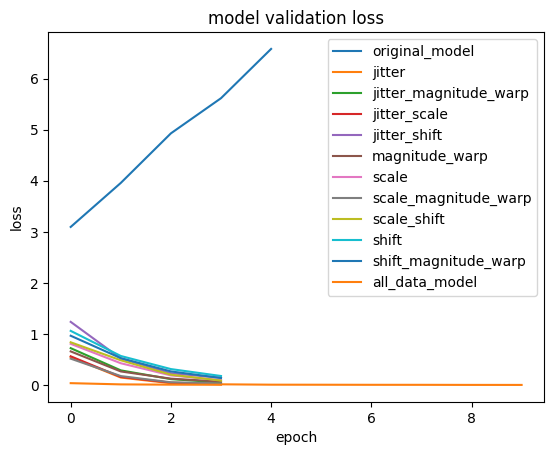

Evaluate model original_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Evaluate model jitter
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step
Evaluate model jitter_magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Evaluate model jitter_scale
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Evaluate model jitter_shift
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
Evaluate model magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
Evaluate model scale
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Evaluate model scale_magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
Evaluate model scale_shift
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
Evaluate model shift
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step
Evaluate model shift_magnitude_warp
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step
Evaluate model all_data_model
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


In [7]:
plot_val_loss(models, history)
acc = []
for model in models:
    # testX = scaler.fit_transform(testX.reshape(-1, testX.shape[-1])).reshape(testX.shape)
    acc.append(evaluate_model(model, testX, testy, class_names))


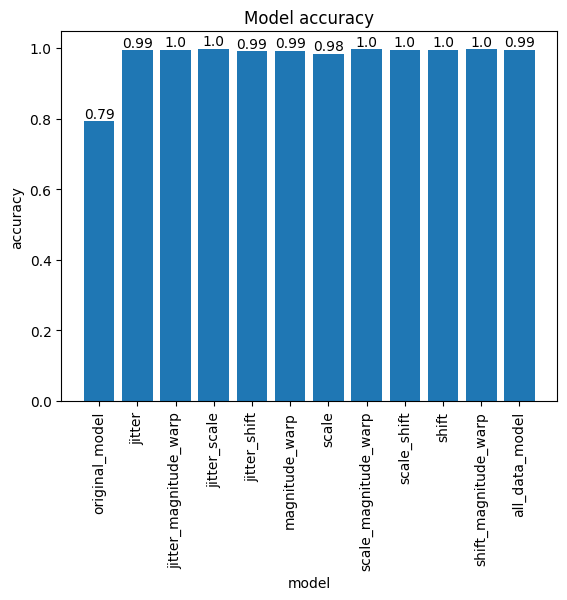

In [8]:
#plot bar chart for accuracy of each model
plt.bar([model.name for model in models], acc)
for i, v in enumerate(acc):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center')

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('model')
plt.xticks(rotation=90)
plt.show()